# ML Models and Performance
This notebook contains 5 models and their performance (accuracy, precision, recall, F1 score in Table 3 of the paper) as well as UMAP embedding and visualization (Figure 5 in the paper) based on the same model features.

In [ ]:
import pickle
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import con_score

import umap
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load/Join Data

In [2]:
df1 = pd.read_csv('../output/DOTA2/processed/dota2_final_09-24.csv')
df2 = pd.read_csv('../output/DOTA2/processed/dota2_final_10-24.csv')
df = pd.concat([df1, df2], axis=0)
df = df.dropna(subset=['radiant_team_id', 'dire_team_id'])

Summary statistics

In [3]:
print("# of unique matches: ", df.match_id.nunique())
print("# of unique leagues: ", df.leagueid.nunique())

unique_radiant_teams = set(df['radiant_team_id'].unique())
unique_dire_teams = set(df['dire_team_id'].unique())
total_unique_teams = len(set(unique_radiant_teams.union(unique_dire_teams)))
print("# of unique teams: ", total_unique_teams)

radiant_teams = set(df['radiant_team_id'].dropna())
dire_teams = set(df['dire_team_id'].dropna())
teams_both_radiant_and_dire = radiant_teams.intersection(dire_teams)
print("Teams that have played on both sides: ", len(teams_both_radiant_and_dire))

# of unique matches:  3274
# of unique leagues:  30
# of unique teams:  504
Teams that have played on both sides:  317


Data Prep

In [4]:
df['start_date_time'] = pd.to_datetime(df['start_date_time'])
df['start_date'] = df['start_date_time'].dt.date
df['week'] = df['start_date_time'].dt.isocalendar().week

In [5]:
df = df.sort_values(by='start_date')
df = df[df['week'].isin(list(range(36,42)))]
df.start_date.nunique(), df.week.nunique()

(42, 6)

In [6]:
df.week.value_counts()

week
39    805
40    512
36    509
41    507
37    473
38    414
Name: count, dtype: Int64

In [7]:
df['winner'] = df.apply(lambda x: x['radiant_team_id'] if x['radiant_win'] == True else x['dire_team_id'], axis=1)
df['loser'] = df.apply(lambda x: x['radiant_team_id'] if x['radiant_win'] == False else x['dire_team_id'], axis=1)

Compute Centrality Measures

In [8]:
con_scores_df = con_score.calculate_CON_multiorder1(df)

In [9]:
con_scores_df_1st = con_scores_df.groupby(['team', 'date']).agg({'1st_order_CON_score': 'sum'}).reset_index()
con_scores_df_2nd = con_scores_df.groupby(['team', 'date']).agg({'2nd_order_CON_score': 'sum'}).reset_index()
con_scores_df_lrg = con_scores_df.groupby(['team', 'date']).agg({'full_CON_score': 'sum'}).reset_index()
con_scores_df_pr = con_scores_df.groupby(['team', 'date']).agg({'pagerank': 'sum'}).reset_index()
con_scores_df_cn = con_scores_df.groupby(['team', 'date']).agg({'closeness': 'sum'}).reset_index()
con_scores_df_id = con_scores_df.groupby(['team', 'date']).agg({'in_degree': 'sum'}).reset_index()
con_scores_df_od = con_scores_df.groupby(['team', 'date']).agg({'out_degree': 'sum'}).reset_index()

In [10]:
con_matrix_1st = con_scores_df_1st.pivot(index='team', columns='date', values='1st_order_CON_score')
con_matrix_1st.columns = [f"1storder_{col}" for col in con_matrix_1st.columns]
con_matrix_1st = con_matrix_1st.fillna(0)

con_matrix_2nd = con_scores_df_2nd.pivot(index='team', columns='date', values='2nd_order_CON_score')
con_matrix_2nd.columns = [f"2ndorder_{col}" for col in con_matrix_2nd.columns]
con_matrix_2nd = con_matrix_2nd.fillna(0)

con_matrix_lrg = con_scores_df_lrg.pivot(index='team', columns='date', values='full_CON_score')
con_matrix_lrg.columns = [f"CON_{col}" for col in con_matrix_lrg.columns]
con_matrix_lrg = con_matrix_lrg.fillna(0)

pr_matrix = con_scores_df_pr.pivot(index='team', columns='date', values='pagerank')
pr_matrix.columns = [f"pagerank_{col}" for col in pr_matrix.columns]
pr_matrix = pr_matrix.fillna(0)

cn_matrix = con_scores_df_cn.pivot(index='team', columns='date', values='closeness')
cn_matrix.columns = [f"closeness_{col}" for col in cn_matrix.columns]
cn_matrix = cn_matrix.fillna(0)

id_matrix = con_scores_df_id.pivot(index='team', columns='date', values='in_degree')
id_matrix.columns = [f"indegree_{col}" for col in id_matrix.columns]
id_matrix = id_matrix.fillna(0)

od_matrix = con_scores_df_od.pivot(index='team', columns='date', values='out_degree')
od_matrix.columns = [f"outdegree_{col}" for col in od_matrix.columns]
od_matrix = od_matrix.fillna(0)

In [11]:
con_matrix_2nd = con_matrix_2nd.reindex(con_matrix_1st.index)
con_matrix_lrg = con_matrix_lrg.reindex(con_matrix_1st.index)
pr_matrix = pr_matrix.reindex(con_matrix_1st.index)
cn_matrix = cn_matrix.reindex(con_matrix_1st.index)
od_matrix = od_matrix.reindex(con_matrix_1st.index)
id_matrix = id_matrix.reindex(con_matrix_1st.index)

In [12]:
combined_matrix = pd.concat([con_matrix_1st, con_matrix_2nd, con_matrix_lrg, 
                             pr_matrix, cn_matrix, od_matrix, id_matrix
                             ], axis=1)
matrix_df_combined = combined_matrix.reset_index()
X = matrix_df_combined.iloc[:, 1:].to_numpy()

In [13]:
matrix_df_combined.CON_39.mean(), matrix_df_combined.CON_39.max()

(63.97160243407708, 1319.0)

In [14]:
def fetch_elo(team_id):
    url = f'https://api.opendota.com/api/teams/{int(team_id)}'
    params = {'api_key': '68d0d3b7-f8a9-4189-a480-92d78d902931'}
    response = requests.get(url, params=params)
    try:
        team = response.json()
        return team['rating']
    except: 
        return None

In [15]:
try:
    all_elos = pd.read_pickle('../output/DOTA2/processed/all_elos_10-24.pkl')
except:
    all_elos = {team_id: fetch_elo(team_id) for team_id in con_scores_df.player.unique()}
    with open('../output/DOTA2/processed/all_elos_10-24.pkl', 'wb') as f:
        pickle.dump(all_elos, f)

In [16]:
mean_elo = np.mean([v for v in all_elos.values() if v is not None])
for k, v in all_elos.items():
    if v is None:
        all_elos[k] = mean_elo

In [17]:
elo_df = pd.DataFrame.from_dict(all_elos, orient='index', columns=['OpenDota Rating']).reset_index().rename(columns={'index': 'team'}).sort_values('team')

Split Rankings into Quantiles (Ground Truth Labels)

In [18]:
quantiles = [0, 0.1, 0.9, 1]
elo_df['elo_quantile'] = pd.qcut(elo_df['OpenDota Rating'], q=quantiles, labels=False)
elo_quantile_counts = elo_df.value_counts('elo_quantile')
print(elo_quantile_counts)

elo_quantile
1    393
0     50
2     50
Name: count, dtype: int64


In [19]:
y = np.array(elo_df['elo_quantile'].astype(int))

Split data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 

In [21]:
np.bincount(y_train)

array([ 35, 275,  35], dtype=int64)

SMOTE

In [22]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [23]:
np.bincount(y_train_smote)

array([275, 275, 275], dtype=int64)

Train models

In [24]:
models = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "SupportVectorClassifier-LINEAR": SVC(random_state=42, kernel='linear'),
    "XGBClassifier": xgb.XGBClassifier(random_state=42),
}

results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []}

predictions = []
for name, model in tqdm(models.items()):
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)

100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


In [25]:
results = pd.DataFrame(results)
display(results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,Precision,Recall,F1-Score
0,GradientBoostingClassifier,0.844595,0.712366,0.644068,0.673401
4,XGBClassifier,0.790541,0.615278,0.582674,0.596374
2,RandomForestClassifier,0.777027,0.639355,0.635217,0.631918
1,DecisionTreeClassifier,0.763514,0.607531,0.629567,0.609616
3,SupportVectorClassifier-LINEAR,0.506757,0.553125,0.599812,0.494636


### UMAP Visualization

In [26]:
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=75, spread=15, min_dist=0.5, metric='euclidean')
embedding = umap_reducer.fit_transform(X, y=y)

C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


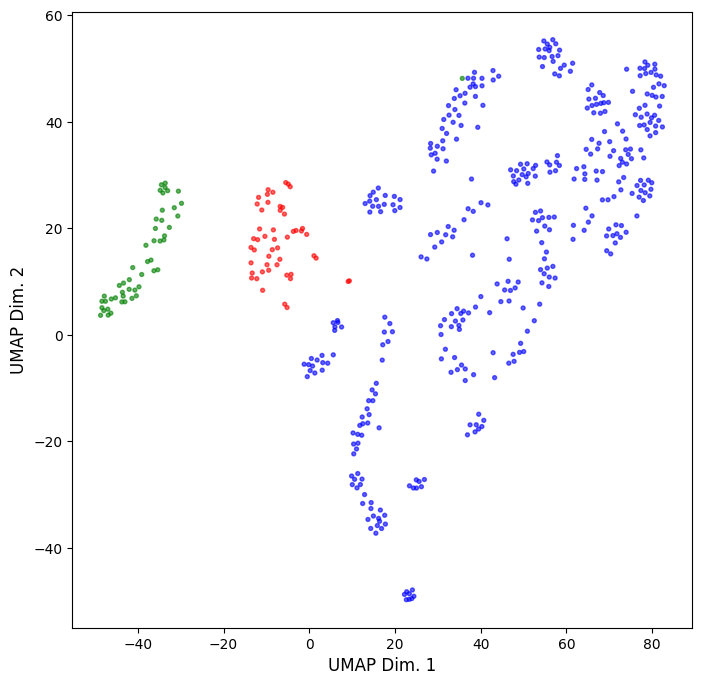

In [27]:
plt.figure(figsize=(8, 8))
color_map = {0: 'red', 1: 'blue', 2: 'green'}
colors = [color_map[label] for label in y]
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors,  s=8, alpha=0.6)
plt.xlabel("UMAP Dim. 1", fontsize=12)
plt.ylabel("UMAP Dim. 2", fontsize=12)
plt.savefig("../output/DOTA2/DOTA2_CON_UMAP.eps", format='eps')
plt.show()

In [29]:
model = models['GradientBoostingClassifier']

In [ ]:
with open("../output/DOTA2/DOTA2_GB_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [32]:
with open("../output/DOTA2/DOTA2_X.pkl", "wb") as f:
    pickle.dump(X, f)

## Feature Importance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


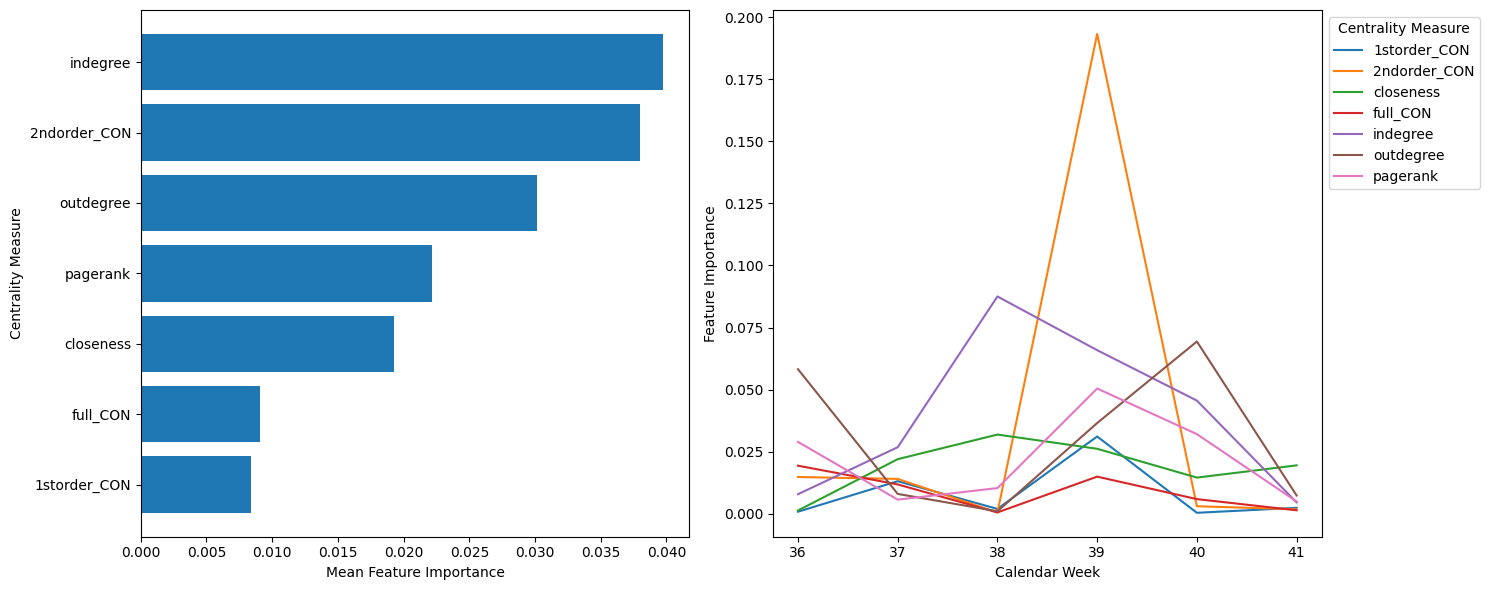

In [31]:
feature_names = matrix_df_combined.iloc[:, 1:].columns
feature_importance = pd.DataFrame({'Feature': feature_names,  'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)

feature_group_mapping = {"2ndorder": "2ndorder_CON", "1storder": "1storder_CON","CON": "full_CON"}

feature_importance['Feature_Group'] = feature_importance['Feature'].str.split('_').str[0]
feature_importance['Feature_Group'] = feature_importance['Feature_Group'].replace(feature_group_mapping)
aggregated_importance = feature_importance.groupby('Feature_Group', as_index=False)['Importance'].mean()
aggregated_importance = aggregated_importance.sort_values(by='Importance', ascending=False)

feature_importance['Time_Step'] = feature_importance['Feature'].str.split('_').str[1]

group_time_mean_importance = feature_importance.groupby(['Feature_Group', 'Time_Step'], as_index=False)['Importance'].mean()

time_step_importance = group_time_mean_importance.pivot(index='Time_Step', columns='Feature_Group', values='Importance')

time_step_importance.index = time_step_importance.index.astype(float).astype(int)
time_step_importance = time_step_importance.sort_index(ascending=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

axs[0].barh(aggregated_importance['Feature_Group'], aggregated_importance['Importance'])
axs[0].set_xlabel('Mean Feature Importance')
axs[0].set_ylabel('Centrality Measure')
axs[0].invert_yaxis()

for group in time_step_importance.columns:
    axs[1].plot(time_step_importance.index, time_step_importance[group], label=group)
    
axs[1].set_xlabel('Calendar Week')
axs[1].set_ylabel('Feature Importance')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), title="Centrality Measure")
axs[1].grid(False)

plt.tight_layout()
plt.savefig("../output/DOTA2/DOTA2_combined_plots.eps", format='eps')
plt.show()